In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
# import torchbnn as bnn
# import torchvision
# import torchvision.transforms as transforms
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
from customized import preprocess
from customized import metrics
from customized.model import rnns
# from customized.model import vae


### Read data

In [2]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')

# User Context Model

## Customer-Streamer Model

### RNN/LSTM/GRU models for Classfication

In [3]:
def policy_generation(algo):

    if  algo == 'GRU':
        policy = rnns.GRU(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BayesGRU':
        policy = rnns.BayesGRU(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'RNN':
        policy = rnns.RNN(input_size, hidden_size, num_layers, num_classes).to(device)
    elif algo == 'BayesRNN':
        policy = rnns.BayesRNN(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'LSTM':
        policy = rnns.LSTM(input_size, hidden_size, num_layers, num_classes).to(device) 
    elif algo == 'BayesLSTM':
        policy = rnns.BayesLSTM(input_size, hidden_size, num_layers, num_classes).to(device)
    return policy

GRU
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 95.03020318506316 %
BayesGRU
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 95.06452498627128 %
RNN
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 95.0164744645799 %
BayesRNN
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 95.0439319055464 %
LSTM
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 94.92037342119714 %
BayesLSTM
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(44145, 130)
(44145,)
Accuracy of the network on the 10000 test inputs: 94.9615595826469 %


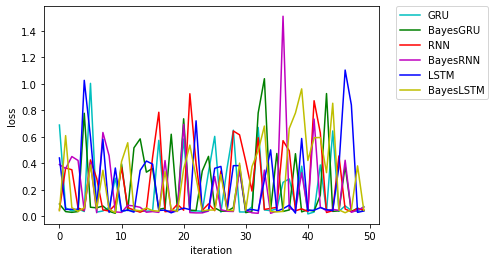

In [4]:
t_record = []
batch_record = []
acc_record = []
samples = []
loss_record = {}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 125 # 25 dim x t seq x 1
end_date = '2022-01-01'
num_classes = 9
num_epochs = 50
learning_rate = 0.001
hidden_size = 128
num_layers = 1
batch_list = [32]
t_list = [i for i in range(5, 6)]
algo_list = ['GRU','BayesGRU','RNN','BayesRNN','LSTM','BayesLSTM']
col = ['c','g', 'r', 'm','b', 'y', 'k', 'w']
c = 0

for algo in algo_list:
    print(algo)
    if algo not in loss_record:
        loss_record[algo] = []
    for b,t in itertools.product(batch_list, t_list):
        print("Sequence legth: ", t, "Batch size:", b)

        ### preprocess streamer data ###
        rfm = preprocess.generate_static_user_context(txn, end_date)
        streamer = preprocess.generate_streamer_features(txn, prod, cmt, rfm, end_date) # 製作streamer features
        scale_streamer = preprocess.standardize(streamer)     # 標準化
        txn_n = preprocess.generate_last_n_txn(txn, t, end_date)        # 找出最後n次交易
        s_seq = preprocess.generate_streamer_seq(txn_n, scale_streamer, t)  # input sequences
        print(s_seq.shape)
        labels_k = dict(zip(streamer.index.to_list(), [i for i in range(0, 9)])) # user_id as key
        # labels_v = dict(enumerate(streamer.index.to_list())) # user_id as value
        s_labels = preprocess.generate_streamer_targets(txn_n, labels_k) # label sequences' targets
        print(s_labels.shape)
        ### preprocess streamer data ###
        
        x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(s_seq, s_labels, test_size=0.33, random_state=2022) # split data

        batch_size = b
        sequence_length = t
        input_size = streamer.shape[1]

        # Read & transform data
        train_dataset = preprocess.StreamerDataset(x_s_train, y_s_train)
        test_dataset = preprocess.StreamerDataset(x_s_test, y_s_test)

        # Load data
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True) # 訓練模型時打亂順序
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False) # 測試集不需要打亂結果也是一樣(因為沒有訓練，是拿已訓練完畢的模型直接產出結果)

        model = policy_generation(algo)

        # Loss and optimizer
        loss_funtion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

        # Train the model
        n_total_steps = len(train_loader) # total sample/N 批次
        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
                # origin shape: [N, 1, 25, t]
                # resized: [N, 25, t] # N:batch
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
                loss = loss_funtion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 1000 == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_record[algo].append(loss.item())

        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in test_loader:
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

            acc = 100.0 * n_correct / n_samples
            print(f'Accuracy of the test inputs: {acc} %') # 72~87
            acc_record.append(acc)
            batch_record.append(batch_size)
            t_record.append(t)
            samples.append(s_seq.shape[0])
        
    plt.plot(range(len(loss_record[algo])), loss_record[algo], c=col[c], ls='-', label=algo)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(labels=algo_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    # axes.set_ylim([0, 1]) # bal, rep, sort
    c += 1
plt.savefig(fname='./fig/loss_rnns.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()


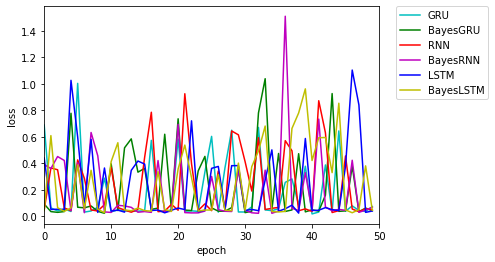

In [20]:
c = 0

for algo in algo_list:
    plt.plot(range(len(loss_record[algo])), loss_record[algo], c=col[c], ls='-', label=algo)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xlim(0, 50)
    plt.legend(labels=algo_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    # axes.set_ylim([0, 1]) # bal, rep, sort
    c += 1
plt.show()

## Customer-Product Model

### Multi-hot Encoding

In [ ]:
product = preprocess.generate_prodcut_features(prod)
scale_prod = preprocess.standardize(product)
prod_n = preprocess.generate_last_n_prod(txn, t, end_date) # 找出最後n次交易
b_seq= preprocess.generate_basket_seq(prod_n, scale_prod, t)
b_targets = preprocess.generate_basket_targets(prod_n, t)
print(b_seq.shape, b_targets.shape)

付款單號不等於t筆: 0
不在商品主檔的商品共有: 0個


In [12]:
t_record2 = []
batch_record2 = []
acc_record2 = []
samples2 = []
loss_record2 = {}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 125 # 25 dim x t seq x 1
num_epochs = 10
learning_rate = 0.001
hidden_size = 128
num_layers = 1
threshold = 0.5
batch_list = [32]
t_list = [i for i in range(5, 6)]
algo_list = ['GRU','GRU_BNN','RNN','RNN_BNN','LSTM','LSTM_BNN']
col = ['c','g', 'r', 'm','b', 'y', 'k', 'w']
c = 0

for algo in algo_list:
    print(algo)
    if algo not in loss_record2:
        loss_record2[algo] = []
    for b,t in itertools.product(batch_list, t_list):
        print("Sequence legth: ", t, "Batch size:", b)


        ### preprocess streamer data ###
        prod_n = preprocess.generate_last_n_prod(txn, t, end_date)        # 找出最後n次交易
        p_seq, p_targets = preprocess.generate_prod_seq_and_target(prod_n, t)  # input sequences
        print(p_seq.shape, p_targets.shape)
        ### preprocess streamer data ###
        
        x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(p_seq, p_targets, test_size=0.33, random_state=2022) # split data

        batch_size = b
        sequence_length = t
        input_size = p_targets.shape[1] # (p_seq.shape/t).astype('int64') 

        # Read & transform data
        train_dataset = preprocess.BasketDataset(x_s_train, y_s_train)
        test_dataset = preprocess.BasketDataset(x_s_test, y_s_test)

        # Load data
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

        model = rnns.GRU(input_size, hidden_size, num_layers, p_targets.shape[1]).to(device) # (5 batch, 25, 5), 128, 2, out_feature_dim

        # Loss and optimizer
        loss_funtion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

        # Train the model
        n_total_steps = len(train_loader) # total sample/N 批次
        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
                # origin shape: [N, 1, 25, t]
                # resized: [N, 25, t] # N:batch
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
                loss = loss_funtion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 10 == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            loss_record2[algo].append(loss.item())

        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in test_loader:
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                # multi-label prediction

                # 法一(小數點6後的尾數 因為把[True, True, False, ...]轉float做mean而與 轉int後加總相除 有些微落差)：
                # print("Accuracy: ", ((outputs > threshold) == labels).float().mean().item()) # Can only calculate the mean of floating types.
                # 法二(先轉換後，逐個計算)：
                outputs[outputs >= threshold] = 1
                outputs[outputs < threshold] = 0
                # print("Accuracy: ", (outputs == labels).sum().item()/(labels.shape[0]*labels.shape[1])) # 直接算product_accuracy
            
            acc = metrics.cal_accurracy_detail(answer=labels, prediction=outputs) # 看完整的資訊
            acc_record2.append(acc)
            batch_record2.append(batch_size)
            t_record2.append(t)
            samples2.append(s_seq.shape[0]) 

    plt.plot(range(len(loss_record2[algo])), loss_record2[algo], c=col[c], ls='-', label=algo)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.legend(labels=algo_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    # axes.set_ylim([0, 1]) # bal, rep, sort
    c += 1
plt.savefig(fname='./loss_rnns2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()
       

GRU
Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0


ValueError: Unstacked DataFrame is too big, causing int32 overflow

### Product Features

In [14]:
t_record3 = []
batch_record3 = []
acc_record3 = []
samples3 = []
loss_record3 = {}

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 2
learning_rate = 0.001
input_size = 112
hidden_size = 128
num_layers = 1
threshold = 0.5
batch_list = [32]
t_list = [i for i in range(5, 6)]
algo_list = ['GRU','GRU_BNN','RNN','RNN_BNN','LSTM','LSTM_BNN']
col = ['c','g', 'r', 'm','b', 'y', 'k', 'w']
c = 0

for algo in algo_list:
    print(algo)
    if algo not in loss_record3:
        loss_record3[algo] = []

    for b,t in itertools.product(batch_list, t_list):
        print("Sequence length: ", t)

        ### preprocess streamer data ###
        product = preprocess.generate_prodcut_features(prod)
        scale_prod = preprocess.standardize(product)
        prod_n = preprocess.generate_last_n_prod(txn, t, end_date) # 找出最後n次交易
        b_seq= preprocess.generate_basket_seq(prod_n, scale_prod, t)
        b_targets = preprocess.generate_basket_targets(prod_n, t)
        print(b_seq.shape, b_targets.shape)
        ### preprocess streamer data ###
        
        x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(b_seq, b_targets, test_size=0.33, random_state=2022) # split data

        batch_size = b
        sequence_length = t

        # Read & transform data
        train_dataset = preprocess.BasketDataset(x_s_train, y_s_train)
        test_dataset = preprocess.BasketDataset(x_s_test, y_s_test)

        # Load data
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

        model = rnns.GRU(input_size, hidden_size, num_layers, b_targets.shape[1]).to(device) # (5 batch, 25, 5), 128, 2, out_feature_dim

        # Loss and optimizer
        loss_funtion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

        # Train the model
        n_total_steps = len(train_loader) # total sample/N 批次
        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
                # origin shape: [N, 1, 25, t]
                # resized: [N, 25, t] # N:batch
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
                loss = loss_funtion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i+1) % 2 == 0:
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
                    loss_record3[algo].append(loss.item())
                    
        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for inputs, labels in test_loader:
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                # multi-label prediction

                # 法一(小數點6後的尾數 因為把[True, True, False, ...]轉float做mean而與 轉int後加總相除 有些微落差)：
                # print("Accuracy: ", ((outputs > threshold) == labels).float().mean().item()) # Can only calculate the mean of floating types.
                # 法二(先轉換後，逐個計算)：
                outputs[outputs >= threshold] = 1
                outputs[outputs < threshold] = 0
                # print("Accuracy: ", (outputs == labels).sum().item()/(labels.shape[0]*labels.shape[1])) # 直接算product_accuracy
            
            acc = metrics.cal_accurracy_detail(answer=labels, prediction=outputs) # 看完整的資訊
            acc_record3.append(acc)
            batch_record3.append(batch_size)
            t_record3.append(t)
            samples3.append(s_seq.shape[0])

    plt.plot(range(len(loss_record2[algo])), loss_record2[algo], c=col[c], ls='-', label=algo)
    plt.ylabel('loss')
    plt.xlabel('iteration')
    plt.legend(labels=algo_list, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axes = plt.gca()
    axes.set_ylim([0, 0.3]) # bal, rep, sort
    c += 1
plt.savefig(fname='./loss_rnns3.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

GRU
Sequence length:  5
付款單號不等於t筆: 0
不在商品主檔的商品共有: 0個


ValueError: Unstacked DataFrame is too big, causing int32 overflow

In [16]:
len(b_seq)

56269

In [17]:
print(pd.__version__)

1.1.5
